# Dependencias y modelo de embedding 

In [33]:
!pip install langchain -q
!pip install langchain_community -q
!pip install pandas -q
!pip install datasets huggingface_hub -q
!pip install PyPDF2 -q
!pip install -U sentence-transformers -q
!pip install -U langchain-ollama -q
!pip install einops -q
!pip install matplotlib -q

In [49]:
import ollama
import pandas as pd
from datasets import Dataset
import PyPDF2
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
import matplotlib.pyplot as plt



### Seleccionar el modelo de embedding 

In [5]:
#model = SentenceTransformer('espejelomar/sentece-embeddings-BETO')
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)

<All keys matched successfully>


# Creación de embeddings del reglamento

In [7]:
with open("_Reglamento.txt", "r", encoding="utf-8") as file:
    texto  = file.read()

articulos = texto.split("Documento:")
articulos = ["Documento:" + articulo.strip() for articulo in articulos if articulo.strip()]
print(f"Existen {len(articulos)} artículos.")

Existen 674 artículos.


In [9]:
articles_embedding = []
for i,article in enumerate(articulos):
    article_embedding = model.encode(article)
    articles_embedding.append((i, article_embedding))

# Retrival: recuperación de articulos más similares

In [12]:
def devolver_N_articulos_similares(pregunta, model, articles_embedding, articulos,N):
    question_embedding = model.encode(pregunta)
    results = []
    
    for i, article_embedding in articles_embedding:  
        distance = cosine_similarity(article_embedding.reshape((1, -1)), question_embedding.reshape((1, -1)))[0][0]
        results.append((articulos[i], distance))
    
    results = sorted(results, key=lambda x: x[1], reverse=True)[:N]
    
    return results


In [13]:
def funcionArticuloEncontrado(lista_articulos_proximos, articulo_correcto):
    for i, (article, _) in enumerate(lista_articulos_proximos):
        if articulo_correcto.strip() == article.strip():
            return i + 1 
    return None  

# Sección de pruebas y evaluación 

## Importanción de DataSet de preguntas etiquetadas


In [14]:
dataset = load_dataset("HuggMaxi/preguntasEtiquetadas")
df_preguntasEtiquetadas = pd.DataFrame(dataset['train'])  
df_preguntasEtiquetadas

,idConsulta,Consulta,Articulo,Texto
0,1,Cuales son las condiciones para presentarse a...,9,Documento:8\nArticulo: 9\nCapitulo: III - INSC...
1,2,Quién debe regir la convocatoria para la desi...,3,Documento:8\nArticulo: 3\nCapitulo: I - CONVOC...
2,3,Cómo se publicita un llamado a concurso?,6,Documento:8\nArticulo: 6\nCapitulo: II - PUBLI...
3,4,Qué contenido tienen los anuncios?,8,Documento:8\nArticulo: 8\nCapitulo: II - PUBLI...
4,5,Cuales son los requisitos para los aspirantes...,9,Documento:8\nArticulo: 9\nCapitulo: III - INSC...
...,...,...,...,...
295,296,Cual es la responsabilidad principal del Esta...,315,Documento:14\nArticulo: 315\nCapitulo: TÍTULO ...
296,297,Que sucede cuando una carrera no obtiene su a...,299,Documento:13\nArticulo: 299\nCapitulo: TÍTULO ...
297,298,Quienes seran los organos de coordinacion y c...,294,Documento:13\nArticulo: 294\nCapitulo: TÍTULO ...
298,299,Que atribuciones tiene la autonomia academica...,250,Documento:13\nArticulo: 250\nCapitulo: TÍTULO ...


## Evaluación por consulta individual 

In [36]:
idConsulta = 1
texto_objetivo = df_preguntasEtiquetadas[df_preguntasEtiquetadas['idConsulta'] == idConsulta]['Texto'].values[0]
pregunta_consulta = df_preguntasEtiquetadas[df_preguntasEtiquetadas['idConsulta'] == idConsulta]['Consulta'].values[0]

resultadoArticulosEncontrados = devolver_N_articulos_similares(pregunta_consulta, model, articles_embedding, articulos,10)
resultadoPosicion = funcionArticuloEncontrado(resultadoArticulosEncontrados, texto_objetivo)

print(f"CONSULTA: {pregunta_consulta}")
print(f"POSICION: {resultadoPosicion}")
print("*********************************************")
print(texto_objetivo)
print("*********************************************")



CONSULTA:  Cuales son las condiciones para presentarse a un concurso?
POSICION: None
*********************************************
Documento:8
Articulo: 9
Capitulo: III - INSCRIPCIÓN

Condiciones de los aspirantes: Para presentarse a Concurso el aspirante debe reunir los siguientes requisitos: a) Tener título universitario de grado o en su defecto acreditar antecedentes excepcionales que lo suplan, y b) no estar comprendido en las causales de inhabilitación para el desempeño de cargos públicos y de faltas a la ética universitaria que se mencionan en el artículo 18 del presente Reglamento.
*********************************************


In [37]:
for i in range(len(resultadoArticulosEncontrados)):
    print(f"-------------------------------------- {i + 1}")
    print(resultadoArticulosEncontrados[i][0])
    print()  

-------------------------------------- 1
Documento:9
Articulo: 68
Capitulo: 

Apruébese el Reglamento de Concurso docente de Antecedentes con Presentación de Proyectos para la provisión de cargos docentes interinos, el que regirá para la cobertura de espacios curriculares en las distintas carreras que se cursan en esta Facultad, y cuyo texto pasa a formar parte de la presente como Anexo Único.

-------------------------------------- 2
Documento:10007
Articulo: 10120
Capitulo: DE LOS CONSEJOS DE CARRERA

Para ser electo como representantes docentes en el consejo de carrera y para ser electos de los mismos se requiere cumplir las condiciones fijadas en el articulo 17º del presente.

-------------------------------------- 3
Documento:15
Articulo: 442
Capitulo: TÍTULO IV: DE LOS CUERPOS UNIVERSITARIOS. SECCIÓN A: De los Docentes Universitarios

Los Consejos Directivos podrán, cuando ello sea imprescindible, designar temporariamente Docentes Interinos y mientras se sustancie el correspondie

## Creación de Dataset de resultados 

In [24]:
batch_size = 10  # Tamaño del lote
total_consultas = len(df_preguntasEtiquetadas)
resultados = []  # Lista para almacenar los resultados antes de crear el DataFrame final

for start in range(0, total_consultas, batch_size):
    # Definir el rango de consultas en el lote
    end = min(start + batch_size, total_consultas)
    batch_df = df_preguntasEtiquetadas.iloc[start:end]
    
    for _, row in batch_df.iterrows():
        idCon = row['idConsulta']
        pregunta_consulta = row['Consulta']
        texto_consulta = row['Texto']
        
        # Obtener los N artículos más similares (N=10 en este caso)
        resultadoPrueba1 = devolver_N_articulos_similares(pregunta_consulta, model, articles_embedding, articulos, 10)
        
        # Encontrar la posición del artículo correcto
        resultadoPosicion = funcionArticuloEncontrado(resultadoPrueba1, texto_consulta)
        
        # Agregar el resultado a la lista de resultados
        resultados.append({
            'idConsulta': idCon,
            'Consulta': pregunta_consulta,
            'Posicion': resultadoPosicion
        })

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados)

# Mostrar el DataFrame
print(resultados_df)


     idConsulta                                           Consulta  Posicion
0             1   Cuales son las condiciones para presentarse a...       NaN
1             2   Quién debe regir la convocatoria para la desi...       1.0
2             3           Cómo se publicita un llamado a concurso?       1.0
3             4                 Qué contenido tienen los anuncios?       7.0
4             5   Cuales son los requisitos para los aspirantes...       1.0
..          ...                                                ...       ...
295         296   Cual es la responsabilidad principal del Esta...       9.0
296         297   Que sucede cuando una carrera no obtiene su a...       1.0
297         298   Quienes seran los organos de coordinacion y c...       7.0
298         299   Que atribuciones tiene la autonomia academica...       NaN
299         300   Cuales son los deberes de los docentes de las...       2.0

[300 rows x 3 columns]


In [38]:
#Convertir 'Posicion' a enteros, manejando los valores NaN como -1
resultados_df['Posicion'] = resultados_df['Posicion'].fillna(-1).astype(int)

In [26]:
#Opcional guardar Dataset


#csv_path = r'C:\Users\Usuario\Documents\GIBD\Archivos_CHATBOT_Reglamentacion\resultados_2.csv'
#resultados_df.to_csv(csv_path, index=False)


## Vizualización de resultados

In [60]:
# RUTAS  EN LA PC DEL LABORATORIO

#csv_path = r'C:\Users\Usuario\Documents\GIBD\RAG\dataSets_Resultados\resultados_beto_llama31_individual.csv'
#csv_path = r'C:\Users\Usuario\Documents\GIBD\RAG\dataSets_Resultados\resultados_nomic_llama31_individual.csv'

#csv_path = r'C:\Users\Usuario\Documents\GIBD\RAG\dataSets_Resultados\resultados_nomic_llama31_similares_TRES.csv'
#csv_path = r'C:\Users\Usuario\Documents\GIBD\RAG\dataSets_Resultados\resultados_nomic_llama31_similares_DIEZ.csv'


In [55]:
# Cargar el archivo CSV en un DataFrame, si es un DataSet importado 
csv_path = r'C:\Users\Usuario\Documents\GIBD\RAG\dataSets_Resultados\resultados_nomic_llama31_similares_TRES.csv'
resultadosCSV_df = pd.read_csv(csv_path)
resultados_df = resultadosCSV_df
print(resultadosCSV_df .head())

   idConsulta                                preguntas_similares  Posicion
0           1  Cuales son las condiciones para presentarse a ...        -1
1           2  Quién debe regir la convocatoria para la desig...         1
2           3  Cómo se publicita un llamado a concurso?\nCómo...         1
3           4  Qué contenido tienen los anuncios?\n¿Cuál es l...         1
4           5  Cuales son los requisitos para los aspirantes ...         1


In [57]:
# Mirar si es la columna Consulta preguntas_similares, dependiendo el dataSet que se cargue

idConsulta = 1
pregunta_consulta = resultados_df[df_preguntasEtiquetadas['idConsulta'] == idConsulta]['preguntas_similares'].values[0]
print(pregunta_consulta)

Cuales son las condiciones para presentarse a un concurso?
¿Qué requisitos hay que cumplir para participar en una competencia académica?
¿Cuáles son los criterios para acceder a un proceso de selección?


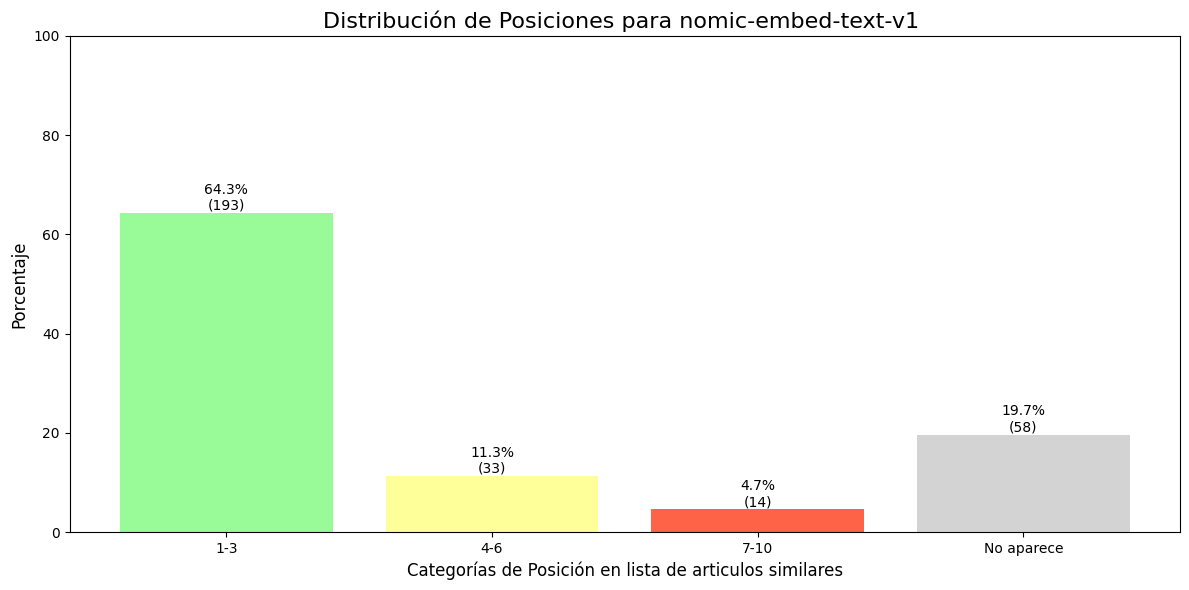

Resultados detallados:
1-3: 64.3% (193 preguntas)
4-6: 11.3% (33 preguntas)
7-10: 4.7% (14 preguntas)
No aparece: 19.7% (58 preguntas)


In [58]:
# Función para categorizar las posiciones
def categorizar_posicion(pos):
    if pos == -1:
        return 'No aparece'
    elif 1 <= pos <= 3:
        return '1-3'
    elif 4 <= pos <= 6:
        return '4-6'
    elif 7 <= pos <= 10:
        return '7-10'
    else:
        return 'No aparece'

# Aplicar la categorización
resultados_df['Categoria'] = resultados_df['Posicion'].apply(categorizar_posicion)

# Calcular los porcentajes y conteos
conteo = resultados_df['Categoria'].value_counts()
porcentajes = (conteo / len(resultados_df)) * 100

# Ordenar las categorías
orden_categorias = ['1-3', '4-6', '7-10', 'No aparece']
conteo = conteo.reindex(orden_categorias)
porcentajes = porcentajes.reindex(orden_categorias)

# Crear el gráfico
plt.figure(figsize=(12, 6))
colores = ['#98FB98', '#FFFF99', '#FF6347', '#D3D3D3']  # Verde, Amarillo pastel, Rojo oscuro, Gris (pasteles)
barras = plt.bar(porcentajes.index, porcentajes.values, color=colores)

plt.title('Distribución de Posiciones para nomic-embed-text-v1 ', fontsize=16)
plt.xlabel('Categorías de Posición en lista de articulos similares', fontsize=12)
plt.ylabel('Porcentaje', fontsize=12)
plt.ylim(0, 100)

# Añadir etiquetas de porcentaje encima de cada barra
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, altura,
             f'{altura:.1f}%\n({int(altura*len(resultados_df)/100)})',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Imprimir resultados detallados
print("Resultados detallados:")
for categoria, porcentaje in porcentajes.items():
    num_preguntas = int(porcentaje * len(resultados_df) / 100)
    print(f"{categoria}: {porcentaje:.1f}% ({num_preguntas} preguntas)")


In [59]:
def mostrar_preguntas_por_posicion(df):
    # Resumen de cantidad por posición
    print("Resumen de cantidad por posición:")
    for posicion in range(1, 11):
        cantidad = df[df['Posicion'] == posicion].shape[0]
        print(f"Posición {posicion}: {cantidad}")
    no_encontradas = df[df['Posicion'] == -1].shape[0]
    print(f"No encontradas: {no_encontradas}")
    
    print("\nPreguntas detalladas por posición:")
    for posicion in range(1, 11):
        preguntas = df[df['Posicion'] == posicion]
        if not preguntas.empty:
            print(f"\nPosición {posicion}:")
            for _, row in preguntas.iterrows():
                print(f"  idConsulta {row['idConsulta']}: {row['Consulta']}")
    
    # Preguntas no encontradas (Posicion == -1)
    no_encontradas = df[df['Posicion'] == -1]
    if not no_encontradas.empty:
        print("\nPreguntas no encontradas:")
        for _, row in no_encontradas.iterrows():
            print(f"  idConsulta {row['idConsulta']}: {row['Consulta']}")

# Ejecutar la función
mostrar_preguntas_por_posicion(resultados_df)

Resumen de cantidad por posición:
Posición 1: 121
Posición 2: 42
Posición 3: 30
Posición 4: 12
Posición 5: 13
Posición 6: 9
Posición 7: 8
Posición 8: 3
Posición 9: 3
Posición 10: 0
No encontradas: 59

Preguntas detalladas por posición:

Posición 1:


KeyError: 'Consulta'